# Creating Data

In [ ]:
import requests
import json
import csv

#API_KEY = 0CUKFG69H3TWK38Y
#STOCK SYMBOL = NVDA
# replace the "demo" apikey below with your own key from https://www.alphavantage.co/support/#api-key
url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=NVDA&outputsize=full&apikey=0CUKFG69H3TWK38Y'   # replace API KEY and stock symbol
r = requests.get(url)
data = r.json()

In [ ]:
# Extract "Time Series (Daily)" part
time_series = data.get("Time Series (Daily)", {})

# Prepare data for CSV
csv_data = [("Date", "Close")]  # Header for CSV file

# Loop through each date and get the "close" price
for date, daily_data in time_series.items():
    close_price = daily_data.get("4. close", None)
    if close_price:
        csv_data.append((date, close_price))

# Write data to CSV file
csv_file = 'test.csv'
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(csv_data)

print(f"Data saved to {csv_file}")

# Preprocessing

In [1]:
import pandas as pd
import numpy as np
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter

# Ανάγνωση των δεδομένων 
Data = pd.read_csv('Stock_prices.csv')
print(Data.head())

# Έλεγχος δεδομένων
Data.info()

         Date    Close
0  2024-11-01  135.400
1  2024-10-31  132.760
2  2024-10-30  139.335
3  2024-10-29  141.250
4  2024-10-28  140.520
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6292 entries, 0 to 6291
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    6292 non-null   object 
 1   Close   6292 non-null   float64
dtypes: float64(1), object(1)
memory usage: 98.4+ KB


In [2]:
# Μετατροπή των στοιχείων του column Date σε datetime
Data['Date']=pd.to_datetime(Data['Date'])

In [3]:
# Εφαρμογή Gaussian Φίλτρου
# Καθορισμός σ (τυπική απόκλιση) για το Gaussian φίλτρο
sigma = 3
# Εφαρμογή Gaussian φίλτρου στην στήλη Close
Data['Close'] = gaussian_filter1d(Data['Close'].values, sigma=sigma)

In [4]:
Data.head()

,Date,Close
0,2024-11-01,137.326641
1,2024-10-31,137.637031
2,2024-10-30,138.181995
3,2024-10-29,138.836434
4,2024-10-28,139.465467


# Data exploration

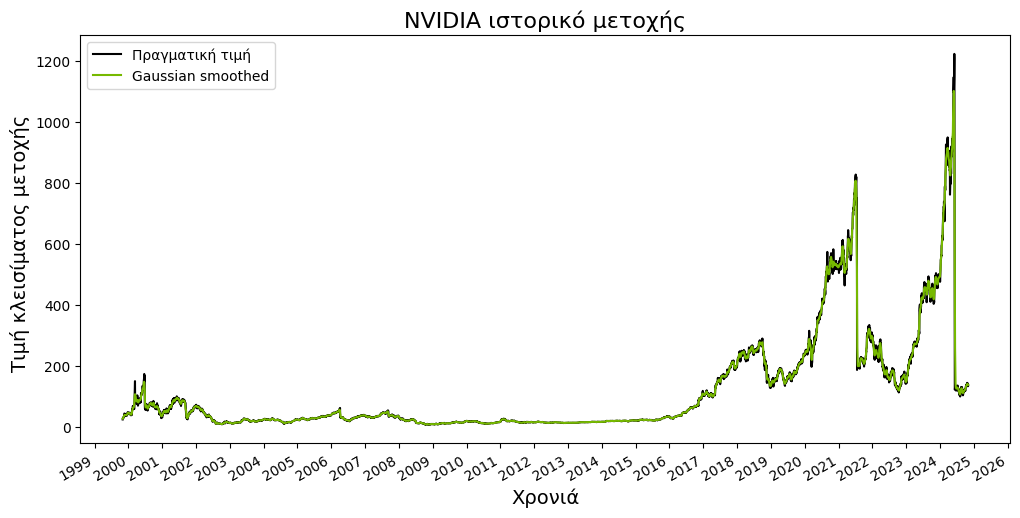

In [6]:
#εισαγωγή βιβλιοθήκης για της ημερομηνίες
import matplotlib.pyplot as plt
import matplotlib.dates as nyears

Raw = pd.read_csv('Stock_prices.csv')
Raw['Date']=pd.to_datetime(Raw['Date'])
# Εξαγωγή ημερομηνιών 
years = nyears.YearLocator()

# Εισαγωγή φόρμας ημερομηνιών 
yearsFmt = nyears.DateFormatter('%Y')

fig, ax = plt.subplots(figsize=(12, 6)) 
ax.plot(Raw['Date'], Raw['Close'], color='Black', label='Πραγματική τιμή')
ax.plot(Data['Date'], Data['Close'], color='#76B900', label='Gaussian smoothed')
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)

# Δημιουργεία γραφήματος
plt.title('NVIDIA ιστορικό μετοχής', fontsize=16)
plt.xlabel('Χρονιά', fontsize=14)
plt.ylabel('Τιμή κλεισίματος μετοχής ', fontsize=14)

# Πειστοφή και ευθυγράμηση των ετικετών 
fig.autofmt_xdate()
plt.legend()
# Εμφάνηση γραφικής 
plt.show()

# Lagged Data

In [7]:
New_data = Data.copy()
New_data_col = []

# Δημιουργία καθυστερημένων στηλών
lagged_col_data = {}  # Λεξικό για αποθήκευση δεδομένων καθυστερημένων στηλών
for i in range(1, 7):
    for col in ['Close']:
        lagged_col_name = f"{col}_{i}"  # Δημιουργία ονόματος καθυστερημένης στήλης
        lagged_col_data[lagged_col_name] = New_data[col].shift(-i)  # Δημιουργία καθυστερημένων στηλών
        New_data_col.append(lagged_col_name)

# Συγχώνευση δεδομένων καθυστερημένων στηλών
New_data = pd.concat([New_data, pd.DataFrame(lagged_col_data)], axis=1)

# Συμπλήρωση τιμών NaN με 0
New_data.fillna(0, inplace=True)

#Μετατροπή του index
New_data.set_index('Date',inplace=True)

# Αφαίρεση της στήλης 'Close' από το DataFrame
New_data_column = New_data.pop('Close')

# Εισαγωγή της στήλης 'Close' στο τέλος του νέου Data Frame 
New_data['Close'] = New_data_column

# Εμφάνιση του πρώτου κομματιού του καθυστερημένου DataFrame για έλεγχο των αλλαγών
print(New_data.head(3))
print(New_data.tail(3))

               Close_1     Close_2     Close_3     Close_4     Close_5  \
Date                                                                     
2024-11-01  137.637031  138.181995  138.836434  139.465467  139.954647   
2024-10-31  138.181995  138.836434  139.465467  139.954647  140.222732   
2024-10-30  138.836434  139.465467  139.954647  140.222732  140.221141   

               Close_6       Close  
Date                                
2024-11-01  140.222732  137.326641  
2024-10-31  140.221141  137.637031  
2024-10-30  139.933043  138.181995  
              Close_1    Close_2  Close_3  Close_4  Close_5  Close_6  \
Date                                                                   
1999-11-03  26.549339  26.317116      0.0      0.0      0.0      0.0   
1999-11-02  26.317116   0.000000      0.0      0.0      0.0      0.0   
1999-11-01   0.000000   0.000000      0.0      0.0      0.0      0.0   

                Close  
Date                   
1999-11-03  26.967507  
1999-11-02 

# Train & Validation Data 

In [8]:
from sklearn.model_selection import train_test_split

def split_data(data):
    print('Διάλεξε ένα έτος μεταξύ 1999 - 2024 για να δημιουργήσεις τα Test Data!')
    t= int(input('Μέχρι ποιο έτος θές να φτάνουν τα δεδομένα εκπαίδευσης :'))
    print('Τα δεδομένα εκπαίδευσης είναι στο διάστημα 1999-11-01 έως '+ str(t)+'-12-29')
    print('Τα δεδομένα επικύρωσης είναι στο διάστημα '+ str(t+1)+'-01-02 έως 2024-11-01')
    # Δεδομένα εκπαίδευσης
    Train_data = data[data.index.year <= t]
    # Δεδομένα επικύρωσης 
    Valid_data = data[data.index.year > t]
    return Train_data, Valid_data

In [9]:
Train_data,Valid_data = split_data(New_data)

#Δημιουργία Train set
X_train = Train_data.drop(['Close'], axis=1) # Εξαίρεση της τελευταίας στήλης, που είναι η ετικέτα κλεισίματος της μςτοχής 
y_train = Train_data['Close']

#Δημιουργία Validation set
X_valid = Valid_data.drop(['Close'], axis=1)  # Εξαίρεση της τελευταίας στήλης, που είναι η ετικέτα κλεισίματος της μςτοχής 
y_valid = Valid_data['Close']

Διάλεξε ένα έτος μεταξύ 1999 - 2024 για να δημιουργήσεις τα Test Data!


Μέχρι ποιο έτος θές να φτάνουν τα δεδομένα εκπαίδευσης : 2023


Τα δεδομένα εκπαίδευσης είναι στο διάστημα 1999-11-01 έως 2023-12-29
Τα δεδομένα επικύρωσης είναι στο διάστημα 2024-01-02 έως 2024-11-01


# Linear regression

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Δημιουργία και εκπαίδευση του γραμμικού μοντέλου
nvidia_model = LinearRegression()
nvidia_model.fit(X_train, y_train)

coefficients = nvidia_model.coef_
intercept = nvidia_model.intercept_
print("Συντελεστές:", coefficients)
print("Βασική τιμή:", intercept)

Συντελεστές: [ 2.15945804 -0.97554341 -0.46186569  0.02714697  0.35388642 -0.10315729]
Βασική τιμή: 0.014244751180257254


# Validation

In [11]:
# Πρόβλεψη επάνω στα δεδομένα επικύρωσης
y_val_pred = nvidia_model.predict(X_valid)

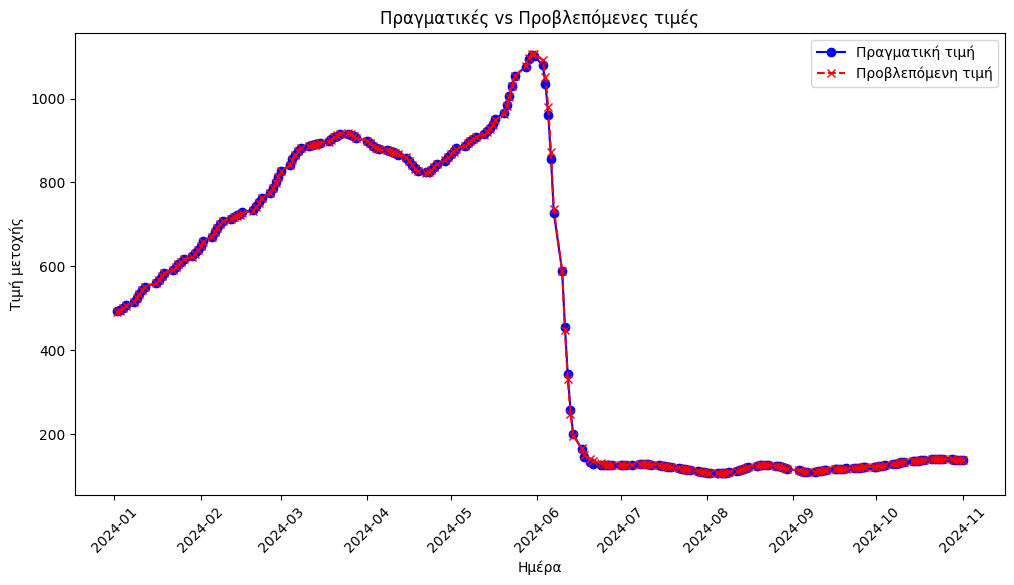

In [12]:
# Δημιουργία γραφικής πραγματικών vs προβλεπόμενων τιμών
plt.figure(figsize=(12, 6))
plt.plot(y_valid.index, y_valid, label='Πραγματική τιμή', color='blue', marker='o')
plt.plot(y_valid.index, y_val_pred, label='Προβλεπόμενη τιμή', color='red', linestyle='--', marker='x')

# Δημιουργία της γραφικής 
plt.title('Πραγματικές vs Προβλεπόμενες τιμές')
plt.xlabel('Ημέρα')
plt.ylabel('Τιμή μετοχής')
plt.legend()
plt.xticks(rotation=45)

# Display the plot
plt.show()

In [13]:
# Υπολογισμός μετρικών σφάλματος
def print_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f" MSE: {mse:.4f}, MAE: {mae:.4f}")

# Εκτύπωση αποτελεσμάτων
print("Validation:")
print_metrics(y_valid, y_val_pred)

Validation:
 MSE: 8.3917, MAE: 1.1412


# Prediction

In [14]:
def data_pred(model):
    x=int(input('Για πόσες μέρες θές να κάνεις πρόβλεψη: '))
    predicted_close = []
    current_close = Raw['Close'].head(6).values.reshape(1, -1)
    for _ in range(x):  
        next_pred = model.predict(current_close)
        predicted_close.append(next_pred[0])
        
        current_close = np.array(current_close).flatten().tolist()[1:]  # Απομάκρυνση της παλαιότερης τιμής 
        current_close.append(next_pred[0])  # Εισαγωγή της νέας πρόβλεψης
        current_close = pd.DataFrame([current_close]) 
    
    # Εμφάνηση προβλεπόμενως τιμών
    print("Πρόβλεψη τιμών κλεισίματος:", predicted_close)

In [15]:
import warnings

# Απόκρυψη των warnings
warnings.filterwarnings("ignore")

# Κλήση της συνάρτης πρόβλεψης
data_pred(nvidia_model)

Για πόσες μέρες θές να κάνεις πρόβλεψη:  1


Πρόβλεψη τιμών κλεισίματος: [np.float64(137.49941005473298)]


# Polynomial regression with L1 & L2 norms

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso, Ridge

def set_degree(train, valid):
    x=int(input("Διάλεξε τον βαθμό του πολυωνύμου: "))
    # Δημιουργία πολυωνυμικών χαρακτηριστικών 
    poly = PolynomialFeatures(degree=x)
    X_train_poly = poly.fit_transform(train)
    X_valid_poly = poly.fit_transform(valid)
    return X_train_poly, X_valid_poly

def set_lasso_par():
    lasso_params = {'alpha': []}
    num = int(input('Εισήγαγε τον αριθμό των υπερπαραμέτρων: '))

    for i in range(1, num + 1):
        x = float(input(f'Εισήγαγε την υπερπαράμετρο {i}: '))
        lasso_params['alpha'].append(x)
    
    # Optionally, you can also add max_iter to the parameters if needed
    max_iter = int(input('Εισήγαγε τον αριθμό επαναλήψεων (max_iter): '))
    lasso_params['max_iter'] = [max_iter]

    return lasso_params
        
def set_ridge_par():
    ridge_params = {'alpha': []}
    num = int(input('Εισήγαγε τον αριθμό των υπερπαράμετρων: '))

    for i in range(1,num+1):
        x=float(input('Εισήγαγε την υπερπαράμετρο{i}: '))
        ridge_params['alpha'].append(x)

    return ridge_params      

In [ ]:
X_train_poly, X_valid_poly = set_degree(X_train, X_valid)
lasso_params = set_lasso_par()
ridge_params = set_ridge_par()

# Διαδικασία GridSearch για Lasso
lasso_grid = GridSearchCV(Lasso(), lasso_params, cv=3, scoring='neg_mean_squared_error')
lasso_grid.fit(X_train_poly, y_train)

# Καλύτερες παραμέτροι και εκτίμηση
best_lasso = lasso_grid.best_estimator_
y_train_pred_lasso = best_lasso.predict(X_train_poly)
y_valid_pred_lasso = best_lasso.predict(X_valid_poly)

# Διαδικασία GridSearch για Ridge
ridge_grid = GridSearchCV(Ridge(), ridge_params, cv=3, scoring='neg_mean_squared_error')
ridge_grid.fit(X_train_poly, y_train)

# Καλύτερες παραμέτροι και εκτίμηση
best_ridge = ridge_grid.best_estimator_
y_valid_pred_ridge = best_ridge.predict(X_valid_poly)

# Υπολογισμός μετρικών σφάλματος
def print_metrics(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{model_name} - MSE: {mse:.4f}, MAE: {mae:.4f}")

# Εκτύπωση αποτελεσμάτων
print("Lasso Regression:")
print_metrics(y_valid, y_valid_pred_lasso, "Validation")

print("\nRidge Regression:")
print_metrics(y_valid, y_valid_pred_ridge, "Validation")

print("\nΚαλύτερες υπερπαράμετροι:")
print("Καλύτερη υπερπαράμετρος για L1:", lasso_grid.best_params_)
print("Καλύτερη υπερπαράμετρος για L2:", ridge_grid.best_params_)

Διάλεξε τον βαθμό του πολυωνύμου:  2
Εισήγαγε τον αριθμό των υπερπαραμέτρων:  4
Εισήγαγε την υπερπαράμετρο 1:  0.001
Εισήγαγε την υπερπαράμετρο 2:  0.01
Εισήγαγε την υπερπαράμετρο 3:  0.1
Εισήγαγε την υπερπαράμετρο 4:  1.0
Εισήγαγε τον αριθμό επαναλήψεων (max_iter):  1000
